In [107]:
#importing the required libraries
import tensorflow as tf
import tensorflow.keras as keras
import nltk
from gensim.models import Word2Vec
import multiprocessing
import os
from keras.initializers import Constant
import matplotlib.pyplot as plt
import keras.backend as K
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
nltk.download("treebank")
print(tf.version)

[nltk_data] Error loading treebank: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
<module 'tensorflow_core._api.v2.version' from '/opt/conda/lib/python3.6/site-packages/tensorflow_core/_api/v2/version/__init__.py'>


In [108]:
#Importing Data from Penn Treebank Dataset
nltk.download("treebank")
sentences_tagged = nltk.corpus.treebank.tagged_sents() #retrieving the data from dataset into a list
print(sentences_tagged[0])
print("Tagged sentences: ", len(sentences_tagged))
print("Tagged words:", len(nltk.corpus.treebank.tagged_words()))

[nltk_data] Error loading treebank: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]
Tagged sentences:  3914
Tagged words: 100676


In [109]:
#Data preprocessing
import numpy as np
sentences, sentence_tags =[], [] 
for tagged_sentence in sentences_tagged:
    sentence, tags = zip(*tagged_sentence)
    sentences.append(sentence)
    sentence_tags.append(tags)
print(sentences[0])
print(sentence_tags[0])

('Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.')
('NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.')


In [110]:
#Build Dictionary, Add the Padding

from sklearn.model_selection import train_test_split
 
tr_sentences, ts_sentences, tr_tags, ts_tags = train_test_split(sentences, sentence_tags, test_size=0.2)

words, tags = set([]), set([])
 
for s in tr_sentences:
    for w in s:
        words.add(w.lower())

for ts in tr_tags:
    for t in ts:
        tags.add(t)

wordtoindex = {w: i + 2 for i, w in enumerate(list(words))}
wordtoindex['-PAD-'] = 0  #special value for padding
wordtoindex['-OOV-'] = 1  #special value for OOVs
 
tagtoindex = {t: i + 1 for i, t in enumerate(list(tags))}
tagtoindex['-PAD-'] = 0  # The special value used to padding

In [111]:
#initializing the parameters of word2vec model
cbow = 0
skipgram = 1
EMBEDDING_DIM = 300 #the higher the dimension the more computationally expensive
minwordcount = 1
workers = multiprocessing.cpu_count() 
contextsize = 7
down_sampling = 1e-3
lr = 0.025 #initial learning rate
min_lr = 0.025 #fixated learning rate
epoch = 15

In [112]:
#defining word2vec model
w2v = Word2Vec(
    sg = skipgram,
    hs = 1, #hierarchical softmax
    size = EMBEDDING_DIM,
    min_count = minwordcount, 
    workers = workers,
    window = contextsize, 
    sample = down_sampling, 
    alpha = lr, 
    min_alpha = min_lr
)
print('Vocabulary size: %d' % len(words))
w2v.build_vocab(tr_sentences)
w2v.train(tr_sentences,epochs=10,total_examples=w2v.corpus_count)
words = list(w2v.wv.vocab)
# save model in word2vec format
filename = 'embd_word2vec.txt'

Vocabulary size: 10121


In [113]:
w2v.wv.save_word2vec_format(filename, binary=False)

In [114]:
#creating embedding matrix
embeddings_index={}
f=open(os.path.join('','embd_word2vec.txt'),encoding="utf-8")
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close()

In [115]:
tr_sentences_X, ts_sentences_X, tr_tags_y, ts_tags_y = [], [], [], []

num_words=len(wordtoindex)+1
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
#print(wordtoindex)
for word,i in wordtoindex.items():
    if i>num_words:
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

In [116]:
#Conversion of sentences and tags to indexes
for s in tr_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(wordtoindex[w.lower()])
        except KeyError:
            s_int.append(wordtoindex['-OOV-'])
 
    tr_sentences_X.append(s_int)

for s in ts_sentences:
    s_int = []
    for w in s:
        try:
            s_int.append(wordtoindex[w.lower()])
        except KeyError:
            s_int.append(wordtoindex['-OOV-'])
 
    ts_sentences_X.append(s_int)

for s in tr_tags:
    tr_tags_y.append([tagtoindex[t] for t in s])

for s in ts_tags:
    ts_tags_y.append([tagtoindex[t] for t in s])

print(tr_sentences_X[0])
print(ts_sentences_X[0])
print(tr_tags_y[0])
print(ts_tags_y[0])

[7691, 3306, 6769, 2946, 3036, 7648, 1917, 5400, 4689]
[2228, 10013, 949, 7387, 430, 1, 1283, 4839, 4911, 1, 4897, 4689]
[33, 33, 33, 43, 20, 3, 20, 20, 16]
[33, 43, 17, 30, 25, 33, 33, 33, 27, 33, 33, 16]


In [117]:
#Padding
from keras.preprocessing.sequence import pad_sequences

MAX_LENGTH = len(max(tr_sentences_X, key=len))
print(MAX_LENGTH)

from keras.preprocessing.sequence import pad_sequences
 
tr_sentences_X = pad_sequences(tr_sentences_X, maxlen=MAX_LENGTH, padding='post')
ts_sentences_X = pad_sequences(ts_sentences_X, maxlen=MAX_LENGTH, padding='post')
tr_tags_y = pad_sequences(tr_tags_y, maxlen=MAX_LENGTH, padding='post')
ts_tags_y = pad_sequences(ts_tags_y, maxlen=MAX_LENGTH, padding='post')
print(tr_sentences_X[0])
print(tr_tags_y[0])

128
[7691 3306 6769 2946 3036 7648 1917 5400 4689    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
[33 33 33 43 20  3 20 20 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [118]:
#Importing the required libraries for creating the model
from keras.models import Sequential
from keras.layers import Dense, CuDNNLSTM,LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation,Dropout
from keras.optimizers import Adam, Nadam
from keras.models import load_model
from keras.optimizers import SGD

#Creating the model

pmodel = Sequential()
embedding_layer=Embedding(num_words, 300,mask_zero=True)
pmodel.add(InputLayer(input_shape=(MAX_LENGTH, )))
pmodel.add(embedding_layer)
pmodel.add(Bidirectional(LSTM(128, return_sequences=True,activation="tanh",recurrent_dropout=0.2)))
pmodel.add(Dropout(0.5))
pmodel.add(Bidirectional(LSTM(128, return_sequences=True,activation="tanh",recurrent_dropout=0.2)))
pmodel.add(Dropout(0.5))
pmodel.add(TimeDistributed(Dense(len(tagtoindex),activation="relu")))
pmodel.add(Activation('softmax'))

pmodel.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.01),    
              metrics=["accuracy"])
pmodel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 300)          3037200   
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 128, 256)          439296    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 128, 256)          394240    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128, 256)          0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 128, 47)           12079     
_________________________________________________________________
activation_6 (Activation)    (None, 128, 47)          

In [119]:
#One-Hot encoding
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)


cat_train_tags_y = to_categorical(tr_tags_y, len(tagtoindex))
print(cat_train_tags_y[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [120]:
result=pmodel.fit(tr_sentences_X, to_categorical(tr_tags_y, len(tagtoindex)),batch_size=256, epochs=10,validation_data=(ts_sentences_X, to_categorical(ts_tags_y, len(tagtoindex))))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3131 samples, validate on 783 samples
Epoch 1/10
3131/3131 [==============================] - 41s 13ms/step - loss: 0.6662 - accuracy: 0.1421 - val_loss: 0.5003 - val_accuracy: 0.3455
Epoch 2/10
3131/3131 [==============================] - 40s 13ms/step - loss: 0.3732 - accuracy: 0.5249 - val_loss: 0.1973 - val_accuracy: 0.7613
Epoch 3/10
3131/3131 [==============================] - 44s 14ms/step - loss: 0.1414 - accuracy: 0.8221 - val_loss: 0.0879 - val_accuracy: 0.8954
Epoch 4/10
3131/3131 [==============================] - 39s 12ms/step - loss: 0.0571 - accuracy: 0.9299 - val_loss: 0.0695 - val_accuracy: 0.9186
Epoch 5/10
3131/3131 [==============================] - 40s 13ms/step - loss: 0.0355 - accuracy: 0.9571 - val_loss: 0.0634 - val_accuracy: 0.9240
Epoch 6/10
3131/3131 [==============================] - 53s 17ms/step - loss: 0.0246 - accuracy: 0.9687 - val_loss: 0.0619 - val_accuracy: 0.9272
Epoch 7/10
3131/3131 [==============================] - 40s 13ms/step - loss:

In [122]:
from keras.models import load_model

pmodel.save("10_Project_2_TT.h5")

pmodel = load_model('10_Project_2_TT.h5')
scores = pmodel.evaluate(ts_sentences_X, to_categorical(ts_tags_y, len(tagtoindex)))
print(pmodel.metrics_names)     
print(scores)

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


783/783 [==============================] - 4s 6ms/step
['loss', 'accuracy']
[0.06313666594268262, 0.9331302642822266]


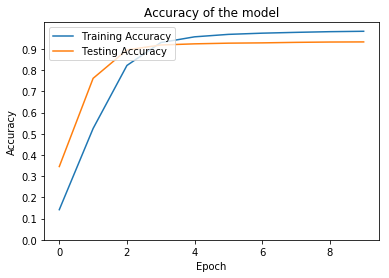

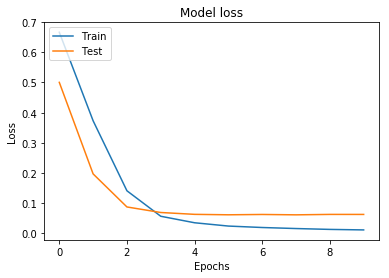

In [125]:
# Plot training & testing accuracy 
plt.figure()
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])

plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Testing Accuracy'], loc='upper left')
plt.yticks(np.arange(0,1,step=0.1))
plt.savefig("Accuracy.png")

plt.figure( )
# Plot training & testing loss 
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training loss', 'Testing loss'], loc='upper left')
plt.savefig("loss.png")

In [126]:
#Testing the model by taking a sequence as input
test_samples = [
    "Adam returned Julie her book in damaged condition".split(),
    "The number of Coronavirus patients is increasing exponentially".split(),
]
 
 
ts_samples = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(wordtoindex[w.lower()])
        except KeyError:
            s_int.append(wordtoindex['-OOV-'])
    ts_samples.append(s_int)

ts_samples = pad_sequences(ts_samples, maxlen=MAX_LENGTH, padding='post')


predictions = pmodel.predict(ts_samples)
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences


final_pred=logits_to_tokens(predictions, {i: t for t, i in tagtoindex.items()})
for x in range(len(test_samples)):
    print(test_samples[x])
    print(final_pred[x][0:len(test_samples[x])])


['Adam', 'returned', 'Julie', 'her', 'book', 'in', 'damaged', 'condition']
['NNP', 'VBD', 'VBN', 'PRP$', 'NN', 'IN', 'VBN', 'NN']
['The', 'number', 'of', 'Coronavirus', 'patients', 'is', 'increasing', 'exponentially']
['DT', 'NN', 'IN', 'JJ', 'NNS', 'VBZ', 'VBG', 'NN']
